Importing the libraries and creating a connection wiht my google drive to import the Datasets.

In [2]:
#!pip install tensorflow==2.12.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
  #raise SystemError('GPU device not found')
else:
  print('I Found a GPU! at: {}'.format(device_name))
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Reshape , Dropout
from sklearn import preprocessing
from keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive') # now I can import files from my Drive

I Found a GPU! at: /device:GPU:0


<ipython-input-2-1a2f4ef06425>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!nvidia-smi # it list the availabe GPUs

# Better to use a LSTM
We want to track a time series input data, better handle by LSTM Recurrent NN. Now let's try to implment it
First, I need to define your LSTM model architecture using Keras. The architecture can be defined using the Sequential API in Keras.

In my case I have an 8  input channel, each linked to a specific sEMG stream coming from a specific muscle.In DL the column of the training set are called features, hence I have 8 feautures.
To enable the LSTM network to keep track of the different activation amounts between the eight channels we need to define a input Dense layer whit shape (num_smaple, 8). We feed each of the 8 neurons whit a specific channel. Then we add a LSTM with 64 neurons and a final Dense layer with 5 neurons and a sigmoid activation function to span the result from 0 to one. the sigmoid function maps any real-valued number to a value between 0 and 1, it is a commonly used nonlinear activation function in neural networks. It is defined as:

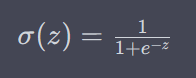
## Time memory capacity
Time Memory Capacity = (Number of Neurons × Number of Time Steps × Size of Each Time Step)
Here's how you can calculate it:


1.   Number of Neurons: The number of neurons in your LSTM layer
2.    Number of Time Steps: This corresponds to the length of the second dimension in your input shape.
3.  Size of Each Time Step: This represents the duration of each time step in milliseconds.

## Input shape of the LSTM

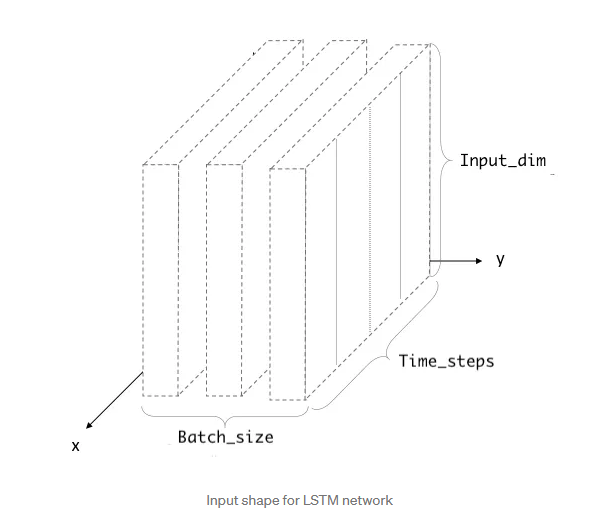

You always have to give a three-dimensional array as an input to your LSTM network. Where the first dimension represents the batch size, the second dimension represents the time-steps and the third dimension represents the number of units in one input sequence. For example, the input shape looks like (batch_size, time_steps, units) that is equal to (number of window, lengh of the window, number of features per window).




### Importing the sEMG pandas datasets



To define the target set, it is necessary to ensure that its first dimension matches that of the training set (the number of rows). We have a training set of shape(num_samples,1, 8), it means with 8 features each wiht dimension 1. We want to have a 5 floats outputs so we need to define a target set of num_sample rows and 5 targets (5 output features).

The training set and the target set has to have the same number of rows, in this case we select 30000 rows that rappresents 30000 time steps of 8 sample each.

## Target dataset

## Data Preprocessing

### Training dataset packing


Here I pack my input data to feed them to the Model during the training process. Furthemore we split the Training dataset in two part, one for the training process and one for the evalution, called Test set.

In [4]:


"""
pd_dataframe_relaxed= {
    'arpeggio_relaxed': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_rilassato/arpeggio_relaxed.csv', sep= ';'),
    'strumming_relaxed': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/2 Strumming/strumming_rilassato/strumming_rilassato_rms.xlsx',sep= ';'),
    'bending_relaxed': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/3 Bending/bending_sliding_rilassato_official/bending_sliding_relaxed.csv',sep= ';'),
    'pullOffHammerOn_relaxed': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/4 PullOffHammerOn/pullOffHammerOn_rilassato/pullOffHammerOn_relaxed.csv',sep= ';'),
    'tapping_relaxed':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/5 Tapping/tapping_relaxed/tapping_relaxed.csv',sep= ';'),
    'downPick_relaxed':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/6 Down_Pick/downPick_relaxed/dowPick_relaxed.csv',sep= ';'),
    'altenatePick_relaxed':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/7 Alternate_Pick/alternatePick_rilassato/alternativePick_relaxed.csv',sep= ';'),
}

"""
pd_dataframe_relaxed_rms= {
    'arpeggio_relaxed': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_rilassato/arpeggio_rilassato_rms.xlsx', sheet_name="Sheet1"),
    'strumming_relaxed': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/2 Strumming/strumming_rilassato/strumming_rilassato_rms.xlsx',sheet_name="Sheet1"),
    'bending_relaxed': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/3 Bending/bending_sliding_rilassato_official/bending_sliding_rms.xlsx',sheet_name="Sheet1"),
    'pullOffHammerOn_relaxed': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/4 PullOffHammerOn/pullOffHammerOn_rilassato/pullOffHammerOn_rilassato_rms.xlsx',sheet_name="Sheet1"),
    'tapping_relaxed':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/5 Tapping/tapping_relaxed/tapping_relaxed_rms.xlsx',sheet_name="Sheet1"),
    'downPick_relaxed':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/7 Alternate_Pick/alternatePick_rilassato/alternatePick_rilassato_rms.xlsx',sheet_name="Sheet1"),
    'altenatePick_relaxed':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/7 Alternate_Pick/alternatePick_rilassato/alternatePick_rilassato_rms.xlsx',sheet_name="Sheet1"),
}

pd_dataframe_contracted_rms= {
    'arpeggio_contracted': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_teso/arpeggio_teso_rms.xlsx', sheet_name="Sheet1"),
    'strumming_contracted': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/2 Strumming/strumming_teso/strumming_teso_rms.xlsx',sheet_name="Sheet1"),
    'bending_contracted': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/3 Bending/bending_sliding_teso/bending_sliding_teso_rms.xlsx',sheet_name="Sheet1"),
    'pullOffHammerOn_contracted': pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/4 PullOffHammerOn/pullOffHammerOnTeso/pullOffHammerOn_teso_rms.xlsx',sheet_name="Sheet1"),
    'tapping_contracted':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/5 Tapping/tapping_teso/tapping_teso_rms.xlsx',sheet_name="Sheet1"),
    'downPick_contracted':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/6 Down_Pick/downPick_teso/downPick_teso_rms.xlsx',sheet_name="Sheet1"),
    'altenatePick_contracted':pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/7 Alternate_Pick/alternatePick_teso/alternatePick_teso_rms.xlsx',sheet_name="Sheet1"),
}

"""

print([pd_dataframe_relaxed[i].isna().sum().sum() for i in pd_dataframe_relaxed], [pd_dataframe_relaxed[i].size for i in pd_dataframe_relaxed])
arpeggio_relaxed= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_rilassato/arpeggio_relaxed.csv', sep= ';')
print(arpeggio_relaxed.shape, arpeggio_relaxed.isna().sum().sum())

pd_dataframe_contracted= {
    'arpeggio_contracted': pd.read_csv('//content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_teso/arpeggio_teso.csv', sep= ';'),
    'strumming_contracted': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/2 Strumming/strumming_teso/strumming_teso.csv',sep= ';'),
    'bending_contracted': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/3 Bending/bending_sliding_teso/bending_sliding_teso.csv',sep= ';'),
    'pullOffHammerOn_contracted': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/4 PullOffHammerOn/pullOffHammerOnTeso/pullOffHammerOn_teso.csv',sep= ';'),
    'tapping_contracted':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/5 Tapping/tapping_teso/tapping_teso.csv',sep= ';'),
    'downPick_contracted':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/6 Down_Pick/downPick_teso/downPick_teso.csv',sep= ';'),
    'alternatePick_contracted':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/7 Alternate_Pick/alternatePick_teso/alternatePick_teso.csv',sep= ';')
}
"""



"\n\nprint([pd_dataframe_relaxed[i].isna().sum().sum() for i in pd_dataframe_relaxed], [pd_dataframe_relaxed[i].size for i in pd_dataframe_relaxed])\narpeggio_relaxed= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_rilassato/arpeggio_relaxed.csv', sep= ';')\nprint(arpeggio_relaxed.shape, arpeggio_relaxed.isna().sum().sum())\n\npd_dataframe_contracted= {\n    'arpeggio_contracted': pd.read_csv('//content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/1 Arpeggio/arpeggio_teso/arpeggio_teso.csv', sep= ';'),\n    'strumming_contracted': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/2 Strumming/strumming_teso/strumming_teso.csv',sep= ';'),\n    'bending_contracted': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe_ThirdAcquisition/3 Bending/bending_sliding_teso/bending_sliding_t

In [5]:
print([pd_dataframe_relaxed_rms[i].isna().sum().sum() for i in pd_dataframe_relaxed_rms], [pd_dataframe_relaxed_rms[i].shape for i in pd_dataframe_relaxed_rms])
print([pd_dataframe_contracted_rms[i].isna().sum().sum() for i in pd_dataframe_contracted_rms], [pd_dataframe_contracted_rms[i].shape for i in pd_dataframe_contracted_rms])
prova=  pd_dataframe_relaxed_rms['arpeggio_relaxed'].iloc[10000:40000,1:]
print(prova.shape)


[0, 0, 0, 0, 0, 0, 0] [(42421, 9), (43802, 9), (42677, 9), (44052, 9), (41427, 9), (43427, 9), (43427, 9)]
[0, 0, 0, 0, 0, 0, 0] [(42927, 9), (50552, 9), (41302, 9), (43302, 9), (42052, 9), (44302, 9), (45177, 9)]
(30000, 8)


In [6]:

scaler = MinMaxScaler()
#trowing away the first and the last 5s of the acquisitions
for i in pd_dataframe_relaxed_rms:
  pd_dataframe_relaxed_rms[i]=  pd_dataframe_relaxed_rms[i].iloc[10000:40000,1:]
  print(pd_dataframe_relaxed_rms[i].shape)
for j in pd_dataframe_contracted_rms:
  pd_dataframe_contracted_rms[j]=  pd_dataframe_contracted_rms[j].iloc[10000:40000,1:]
  print(pd_dataframe_contracted_rms[j].shape)
#print([pd_dataframe_relaxed_rms[i].isna().sum().sum() for i in pd_dataframe_relaxed_rms], [pd_dataframe_relaxed_rms[i].shape for i in pd_dataframe_relaxed_rms])
#print(pd_dataframe[i].shape for i in pd_dataframe)
#scaling the values from [0,1]
#pd_datafrma= sclaler.fit_transform(pd_datafrma)
"""
#be sure that all the column has the same name otherwise pd.concat will create another column
new_columns_name = ['RMS_ Brachioradialis  Sx ', 'RMS_ Brachioradialis  Dx ',
       'RMS_ Extensor Carpi Radialis Sx ', 'RMS_ Extensor Carpi Radialis  Dx ',
       'RMS_ Triceps brachii Long Head Dx ', 'RMS_ Deltoid  Lateral  Dx ',
       'RMS_ Abductor digiti minimi (hand) Sx ',
       'RMS_ Abductor digiti minimi (hand) Dx']"""

#I need to implement a binary classifier
#using the function pd.concat i can concatenate multiple pd dataframe

#dataframes_class_0 = ['arpeggio', 'bending', 'strongPick']
#concatenated_df_class0 = pd.concat([pd_dataframe[df] for df in dataframes_class_0], axis=0)
concatenated_df_class0 = pd.concat([pd_dataframe_relaxed_rms[df] for df in pd_dataframe_relaxed_rms], axis=0)

#dataframes_class_1 = ['strumming', 'doublePick', 'tapping','pullOffHammerOn']
#changing the name of the columns to ensure the same names for each dataframe
#for i in dataframes_class_1:
  #pd_dataframe[i].columns = new_columns_name
#print([pd_dataframe[df].columns for df in dataframes_class_1])
concatenated_df_class1 = pd.concat([pd_dataframe_contracted_rms[df] for df in pd_dataframe_contracted_rms], axis=0)

#print(concatenated_df_class1.shape)

pd_binary_df ={
    'calm': concatenated_df_class0,
    'frenetic': concatenated_df_class1
}

print([pd_binary_df[i].shape for i in pd_binary_df])

for i in pd_binary_df:
  #remamber: the training set has to look like (samples, time_steps, features)

  #pd_dataframe[i]= pd_dataframe[i].iloc[5000:35031].values # excluding the first and the last 5 second of samples
  pd_binary_df[i] = scaler.fit_transform(pd_binary_df[i])
  # Define the sequence length

  sequence_length = 128

  # Calculate the number of groups
  num_groups = pd_binary_df[i].shape[0] // sequence_length


  # Calculate the number of remaining elements
  num_remaining = pd_binary_df[i].shape[0] % sequence_length


  # Reshape the input data into a 3D matrix
  #print('the shape before reshaping ', pd_binary_df[i][:num_groups * sequence_length])

  input_sequences = np.reshape(pd_binary_df[i][:num_groups * sequence_length], (num_groups, sequence_length, pd_binary_df[i].shape[1]))

  pd_binary_df[i] = input_sequences

  # The shape of 'input_sequences' will be (num_groups + 1, sequence_length, num_features)
  print(pd_binary_df[i].shape)

  #pd_dataframe[i]= np.reshape(pd_dataframe[i],(pd_dataframe[i].shape[0], 1, pd_dataframe[i].shape[1]))


#Printing some statistics
for i in pd_binary_df.keys():
  print('mean and variance and shape of', i ,' = {:.3f}, {:.3f}, {}'.format(np.nanmean(pd_binary_df[i]), np.nanvar(pd_binary_df[i]), pd_binary_df[i].shape ))

(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
(30000, 8)
[(210000, 8), (210000, 8)]
(1640, 128, 8)
(1640, 128, 8)
mean and variance and shape of calm  = 0.136, 0.034, (1640, 128, 8)
mean and variance and shape of frenetic  = 0.111, 0.020, (1640, 128, 8)


In [7]:

target_dict = {
  'calm': 0,
  'frenetic': 1
}
shape1= pd_binary_df['calm'].shape[0]
#populate the dictionaty with the right shapes before using them as target set
#i have to create a target set with 938 rows and 7 columns
for i in target_dict:
  target_dict[i]= np.tile(target_dict[i], (pd_binary_df[i].shape[0],1))

print([i.shape for i in  target_dict.values()])

[(1640, 1), (1640, 1)]


In [8]:

concatenated_training_datasets= np.concatenate(([pd_binary_df[key] for key in pd_binary_df.keys()]),axis=0)
#print(x_train.shape)
concatenated_target_datasets= np.concatenate(([target_dict[key] for key in target_dict.keys()]), axis= 0)
#print(y_train.shape)
#splitting the dataset into a training and testing dataset

X_train, X_test, Y_train, Y_test = train_test_split(concatenated_training_datasets, concatenated_target_datasets, test_size=0.2, random_state=42)
print('The shape of the training&validation set: ',X_train.shape,Y_train.shape,'The shape of the test&validation set: ', X_test.shape, Y_test.shape)

The shape of the training&validation set:  (2624, 128, 8) (2624, 1) The shape of the test&validation set:  (656, 128, 8) (656, 1)


It does not have any senso to put as a imput layer a dense layer. it distracts the LSTM from the time-series analysis, the input layer before the lstm is usualy used when you have a higher values of input features, and you want to do some inference before classify the time series data. The input dense of CNN layer is used to reduce the number of features (parameters) before feed the LSTM. In this case we do not need to use a input dense layer because the number of features is low. We can use it after the LSTM if it encrease the performance.

In [145]:


time_steps =128 #we feed the model with 32 consecuitive samples to  discover the pattern
n_features = 8 # we have 8 sEMG sample for each  new input sample it means 8 features  for each sample

input_shape= (time_steps, n_features)# each sample of new data is rappresented by 8 time steps in our dataset and each time step has feauture shape of 1
#n_features is the number of features or variables at each time step.

model = Sequential()
#By setting the input shape to (8, 1), you are specifying that each sample consists of 8 time steps, each time step consisting of a single feature
# Add an input dense layer with 8 neurons, one for each column in the input dataset


from keras.regularizers import l2
# Add an LSTM layer with 64 units
model.add(LSTM(128, input_shape= input_shape ,return_sequences=True, kernel_regularizer=l1(0.01))) # when you want to stack multiple LSTM
#you have to set the return_sequences=True to not have shape problems.

model.add(Dropout(0.1))  # add a dropout layer with dropout rate of 0.2
#I reduce the levels of neurons of the second LSTM to reduce the overfitting
model.add(LSTM(64, return_sequences=True,kernel_regularizer=l2(0.001))) #kernel_regularizer=l2(0.05)
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=False))
# Add a dense output layer with 5 units and linear activation
model.add(Dense(1, activation='sigmoid')) #return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False. IT should be set true only in the output layer

print('The output shape: ',model.output_shape, ' the input shape: ', model.input_shape)
model.summary()

The output shape:  (None, 1)  the input shape:  (None, 128, 8)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 128, 128)          70144     
                                                                 
 dropout_40 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_74 (LSTM)              (None, 128, 64)           49408     
                                                                 
 dropout_41 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_75 (LSTM)              (None, 32)                12416     
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                        

### Compiling the Model
To compile the network (before training it) we have to choose the Optimizer and the loss function:

The optimizer is the algorithm used to update the weights of the model during training, and 'adam' is a popular optimizer that adapts the learning rate of each weight based on the first and second moments of the gradients.

The loss function is used to measure how well the model is performing on the training data and guides the optimization process. 'mse' stands for mean squared error, which is a common loss function used for regression problems where the goal is to minimize the difference between the predicted and actual values.

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Learning rate: The learning rate determines how much the model weights are updated during training. A larger learning rate can lead to faster convergence, but can also cause the model to overshoot the minimum. By reducing the learning rate, the model's training will progress at a slower pace, potentially leading to more accurate results, especially if you were previously experiencing convergence issues or overshooting the optimal solution. In our case the loss function is converging too fast, so we reduce the learning rate.

Showing the availables parameters of the network

In [146]:
# Compile the model

#model.compile(optimizer='adam', loss='mse', metrics=['mse'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
from keras.optimizers import RMSprop

learning_rate = 0.05  # Set a lower learning rate value

#optimizer = Adam(learning_rate=learning_rate)  # Specify the optimizer with the desired learning rate

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0009), metrics=['accuracy']) #learning_rate=0.0009
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the model


In [147]:
"""
# Load data from pandas dataframe dictionary
X_1 = pd_dataframe['arpeggio'] # Return a Numpy representation of the DataFrame. Only the values in the DataFrame will be returned, the axes labels will be removed.
#print(type(X_1))
X_1= tf.stack(X_1)
y_1 = target_dict['arpeggio']

X_2 = pd_dataframe['strumming'] # Return a Numpy representation of the DataFrame. Only the values in the DataFrame will be returned, the axes labels will be removed.
print(type(X_2))
X_2= tf.stack(X_2)
y_2 = target_dict['strumming']
print('output shape ', y_1.shape, ' input shape  ', X_1.shape )
"""
#print( [pd_dataframe[key] for key in pd_dataframe.keys()])

# Fit the model with different datates each associated to a specific output target
#create a list of datasets tuple to train the model
history = model.fit(X_train,Y_train,batch_size=64, validation_split=0.2, epochs=200)


Epoch 1/200
33/33 [==============================] - 7s 53ms/step - loss: 2.2333 - accuracy: 0.6489 - val_loss: 1.6859 - val_accuracy: 0.7448
Epoch 2/200
33/33 [==============================] - 1s 17ms/step - loss: 1.3474 - accuracy: 0.6851 - val_loss: 1.0268 - val_accuracy: 0.7352
Epoch 3/200
33/33 [==============================] - 1s 18ms/step - loss: 0.8772 - accuracy: 0.7165 - val_loss: 0.7083 - val_accuracy: 0.7619
Epoch 4/200
33/33 [==============================] - 1s 18ms/step - loss: 0.7009 - accuracy: 0.7351 - val_loss: 0.6544 - val_accuracy: 0.7562
Epoch 5/200
33/33 [==============================] - 1s 17ms/step - loss: 0.6967 - accuracy: 0.7203 - val_loss: 0.6540 - val_accuracy: 0.7771
Epoch 6/200
33/33 [==============================] - 1s 18ms/step - loss: 0.6284 - accuracy: 0.7399 - val_loss: 0.6050 - val_accuracy: 0.7333
Epoch 7/200
33/33 [==============================] - 1s 18ms/step - loss: 0.6233 - accuracy: 0.7323 - val_loss: 0.5957 - val_accuracy: 0.7390
Epoch 


The validation_split argument in Keras fit method specifies the fraction of the training data to be used as validation data. The model will not be trained on the validation data, but rather the validation data will be used to evaluate the model's training performance over the epochs on data it has not seen before.

For example, if validation_split=0.2, then 20% of the training data will be used as validation data and the remaining 80% will be used as the training data. The validation data will be used to evaluate the model's performance after each epoch during training. The validation set is a portion of the training set to evaluate the training process, instead to evaluate the network we have to use a different dataset called testing dataset.
I changed the batch_size to 64 and the number of epoch to reach the loss convergence. Addictionaly, I added a new LSTM layer of 64 neurons and added a dropOut(0.1). You have to keep dropOut always small and play with the batch_size and #epochs to reach convervence. I changed the optimizer to RMSprop, trying different learning rate. The learning rate is a delicate parameter, a litle change of learning rate completly changed the performance resultin in very strange accurancy/loss behaviur. I finally set the learning rate to 0.0009, default value is 0.01.


### Plotting the Loss function and the MSE
We can track the training accurancy to avoid overfitting by plotting the loss function and the MSE for each epoch. The MSE is a common metric to evaluate regession task. The lower the loss, the better the model performance. The purpose of the loss function is to evaluate how well the model is learning the patterns in the data and adjusting its weights and biases to make accurate predictions. So, when you train a model, you try to minimize the loss function by adjusting the model's parameters. In other evaluation metrics, such as accuracy or F1 score, the higher the value, the better the model performance.
Ploting the training history.

If after few epochs the loss function tend to reach the platoe and does not change too much it means that the system is overfitting. The fluctuating validation accuracy and the minimal change in the loss function after the initial epochs suggest that the model might not be generalizing well to unseen data. Fluctuating validation accuracy typically indicates that the model is struggling to generalize its learning from the training set to new examples in the validation set.
This could be a sign of overfitting, where the model becomes too specialized in the training data and fails to generalize well. Overfitting often occurs when the model's capacity is too high compared to the amount and diversity of the available training data.

<ipython-input-148-e0f40003426d>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


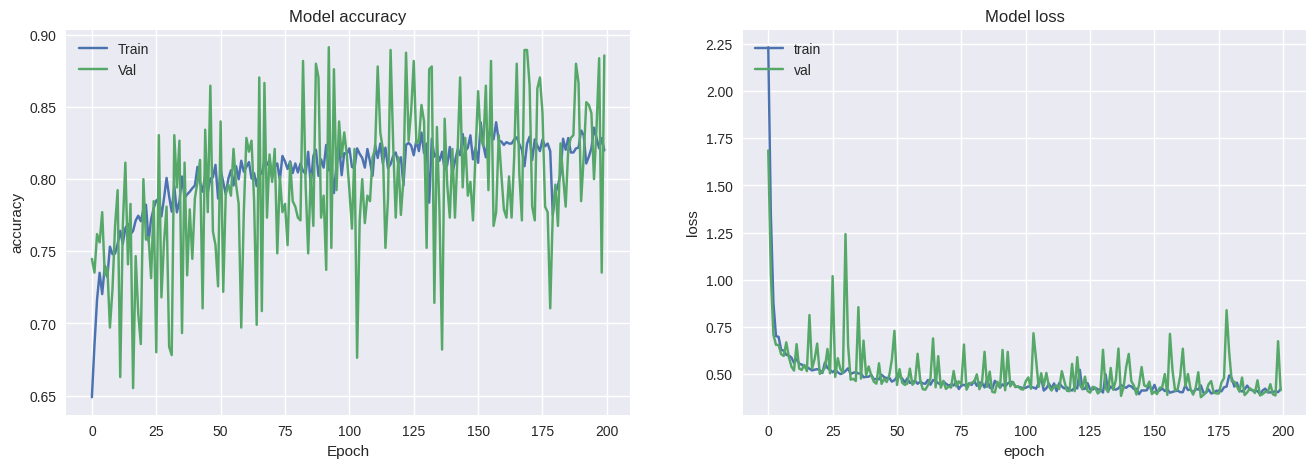

In [148]:
# list all data in training history
#print(history.history.keys())

plt.figure(figsize=(16,5))
plt.title('arpeggio')
plt.subplot(1,2,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## Model Evaluation
Testing the model whit a testing set computing the loss function for an unseen dataset. fixare la cross validatin che non funziona

In [152]:
model.evaluate(X_test,Y_test)
#loss: 0.4092 - accuracy: 0.8628 the best perfomance so far with the model lstm_128_64_32

21/21 [==============================] - 0s 13ms/step - loss: 0.4092 - accuracy: 0.8628


[0.4092022180557251, 0.8628048896789551]

In [ ]:
#divide in training set e test
#the testing dataset have to be useen data but whith a trained target set, you can use a dataset belonging to a target that you did not train.
#in the training the network see the label, in the tasting set it see the label only at the end, but shold be data from a studied label otherwise it has no sense.
#it has to be data belonging to one of the category which you use during the training but unseen during the training stage.
#you have to split the training dataset to obtai a testing dataset
"""
## Model evaluation
from sklearn.model_selection import StratifiedKFold
# Define the number of folds
n_folds = 10

# Initialize the cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store the evaluation results
accuracy_scores = []
loss_scores = []

# Perform cross-validation
for train_idx, val_idx in kfold.split(X_train, Y_train):
    # Split the data into training and validation sets
    x_train_1, x_val_1 = X_train[train_idx], X_train[val_idx]
    y_train_1, y_val_1 = Y_train[train_idx], Y_train[val_idx]

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train_1, y_train_1, epochs=10, batch_size=32, verbose=0)
    #y_val= np.argmax(y_val, axis=1)
    # Evaluate the model on the validation set
    scores = model.evaluate(x_val_1, y_val_1, verbose=0)

    # Store the evaluation results
    loss_scores.append(scores[0])
    accuracy_scores.append(scores[1])

# Calculate and print the average performance metrics
print("Average loss: ", np.mean(loss_scores))
print("Average accuracy: ", np.mean(accuracy_scores))
"""


Now we have to actualy try the regression, we could use the method model.predict

In [ ]:
# Reshape the data to match the input shape of the model
new_data= pd_binary_df['calm'][400]

new_data= np.reshape(new_data,(1,new_data.shape[0], new_data.shape[1]))
print(new_data.shape)
#new_data = new_data.reshape(1, -1)

# Make a prediction using the model
prediction = model.predict(new_data)
print(prediction)
index= np.argmax(prediction)
print(np.argmax(prediction), prediction.shape)

## Exporting the model
Now we want to save the model to use it in RawPower


In [151]:
# Save the model

"""
kernel_regularizer=l1(0.01)
Dropout(0.1)
optimizer=RMSprop(learning_rate=0.0009)
batch_size=16


evaluate: loss: 0.4204 - accuracy: 0.7973
"""
#model.save('sEMG_binary_classifier_128_thirdAcquisition.h5')

"""
# ho aggiunto un altro layer da 64 con regolarizazione l2 e un dropOut(0.1)
kernel_regularizer=l1(0.01)
Dropout(0.1)
kernel_regularizer=l2(0.001)
Dropout(0.1)
optimizer=RMSprop(learning_rate=0.0009)
batch_size=64
epochs=200


evaluate: loss: 0.4204 - accuracy: 0.7973
"""

model.save('sEMG_binary_classifier_128_128_64_thirdAcquisition.h5')





be sure to have alla the requirements to run the model

In [ ]:
!pip freeze > requirements.txt
!pip freeze